## Import

In [1]:
import sys; sys.path.insert(0, '..')
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from df_utils import df_wrapper, get_timestamp_and_pose, POSE_MAP, combine_dataframes
from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical

## Define data

In [2]:
from file_declarations import training_class, testing_class, training_files, testing_files
testing_file = testing_files["Xiaomeng"]
AMOUNT_OF_SENSORS = 3

## Datapreparation

### Train

In [3]:
knn_train = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    stamped_poses = get_timestamp_and_pose(training_files[key].annot_file, POSE_MAP)
    elem.align_poses(stamped_poses)
    knn_train.append(elem)

y_train = pd.concat([x.df['Pose'] for x in knn_train])

../df_utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../df_utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../df_utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

### Test

In [4]:
knn_test = df_wrapper(testing_file.csv_file)
knn_test.concat_sensor_data(AMOUNT_OF_SENSORS)
test_stamped_poses = get_timestamp_and_pose(testing_file.annot_file, POSE_MAP)
knn_test.align_poses(test_stamped_poses)
y_test = knn_test.df["Pose"]
y_test.index = [i for i in range(len(y_test))]

../df_utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \


## Visualisation

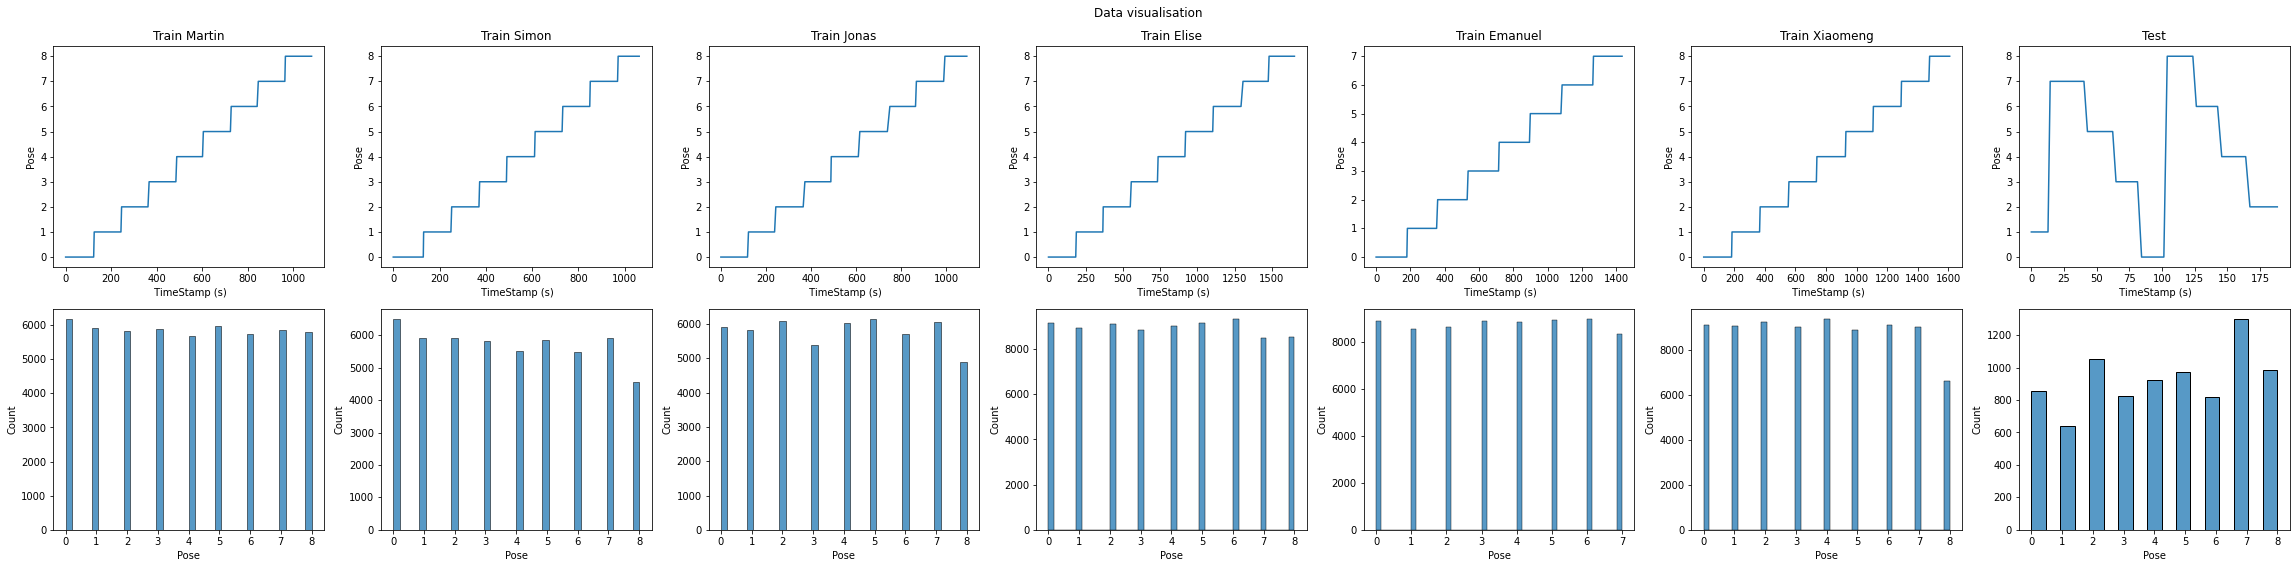

In [5]:
cols = []
height=8
width=(height/1.5)*len(knn_train)
fig, axes = plt.subplots(2, len(knn_train)+1, figsize=(width, height))
fig.suptitle('Data visualisation')
for i in range(len(knn_train)):
    sns.lineplot(ax=axes[0, i], data=knn_train[i].df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=knn_train[i].df["Pose"])
    cols.append('Train')    
for i, key in enumerate(training_files):
    cols[i] += f' {key}'
sns.lineplot(ax=axes[0, len(knn_train)], data=knn_test.df, x=" TimeStamp (s)", y='Pose')
sns.histplot(ax=axes[1, len(knn_train)], data=y_test)
cols.append('Test')
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

## Adjust dataframes

In [6]:
x_train = combine_dataframes([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in knn_train])
x_test = knn_test.df.drop([' TimeStamp (s)', 'Pose'], axis=1) 

x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(386320, 48)
(386320,)
(8367, 48)
(8367,)


## Add scaler

In [7]:
#scaler = MinMaxScaler()
#scaler.fit(x_train_numpy)
#x_train_numpy = scaler.transform(x_train_numpy)
#x_test_numpy = scaler.transform(x_test_numpy)

y_train = to_categorical(y_train_numpy,9)
y_test = to_categorical(y_test_numpy,9)

## Hyperparams

In [8]:
EPOCH = 20
BATCH_SIZE = 10000
LR = 0.00050
DROPOUT_RATE1 = 0.4
DROPOUT_RATE2 = 0.4
ACTIVATION1 = 'relu'
ACTIVATION2 = 'softmax'
OPTIM = Adam(learning_rate=LR)
#OPTIM = RMSPROP(learning_rate=LR)

# Shapes
OUTPUT_SHAPE = 9
LAYER1_SHAPE = AMOUNT_OF_SENSORS*16
LAYER2_SHAPE = int((LAYER1_SHAPE+OUTPUT_SHAPE)/2)

## Model

In [9]:
model = Sequential()
model.add(Dense(LAYER1_SHAPE, activation=ACTIVATION1))
#model.add(Dropout(rate=DROPOUT_RATE1))
model.add(Dense(LAYER2_SHAPE, activation=ACTIVATION1))
model.add(Dropout(rate=DROPOUT_RATE2))
model.add(Dense(OUTPUT_SHAPE, activation=ACTIVATION2))

model.compile(optimizer=OPTIM, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

## Fit the model

In [10]:
model.fit(x=x_train_numpy, y=y_train, batch_size=BATCH_SIZE, validation_data=(x_test_numpy, y_test), shuffle=True, epochs=EPOCH)


Epoch 1/20
39/39 [==============================] - 2s 50ms/step - loss: 31.7906 - accuracy: 0.1191 - val_loss: 6.0220 - val_accuracy: 0.1002
Epoch 2/20
39/39 [==============================] - 1s 19ms/step - loss: 10.8448 - accuracy: 0.1853 - val_loss: 2.4940 - val_accuracy: 0.1008
Epoch 3/20
39/39 [==============================] - 1s 19ms/step - loss: 4.0036 - accuracy: 0.2697 - val_loss: 1.4845 - val_accuracy: 0.2393
Epoch 4/20
39/39 [==============================] - 1s 19ms/step - loss: 1.9244 - accuracy: 0.3944 - val_loss: 1.3719 - val_accuracy: 0.4619
Epoch 5/20
39/39 [==============================] - 1s 19ms/step - loss: 1.3885 - accuracy: 0.4801 - val_loss: 1.2878 - val_accuracy: 0.5256
Epoch 6/20
39/39 [==============================] - 1s 20ms/step - loss: 1.1812 - accuracy: 0.5379 - val_loss: 1.2224 - val_accuracy: 0.5231
Epoch 7/20
39/39 [==============================] - 1s 19ms/step - loss: 1.0677 - accuracy: 0.5749 - val_loss: 1.1553 - val_accuracy: 0.5426
Epoch 8/20


## Visualise the loss

<AxesSubplot:>

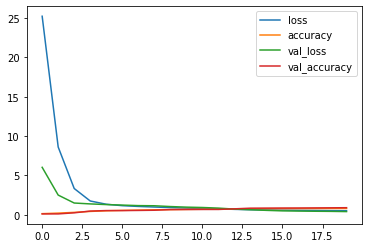

In [11]:
history = pd.DataFrame(model.history.history)
history.plot()

## Predict

In [12]:
import time
start = time.perf_counter()
predictions = model.predict(x_test_numpy)
print(time.perf_counter() - start)
predictions_final = []  
y_test_arr = []
for index in range(len(predictions)):
    predictions_final.append(predictions[index].argmax())
    y_test_arr.append(y_test[index].argmax())

number_of_corrects = 0
for i in range(len(predictions_final)):
    if(predictions_final[i] == y_test_arr[i]):
        number_of_corrects += 1
print(number_of_corrects)
print("% of corrects: {}".format(number_of_corrects/len(predictions_final)*100))

0.22012995299883187
7449
% of corrects: 89.02832556471853


## Visualise prediction

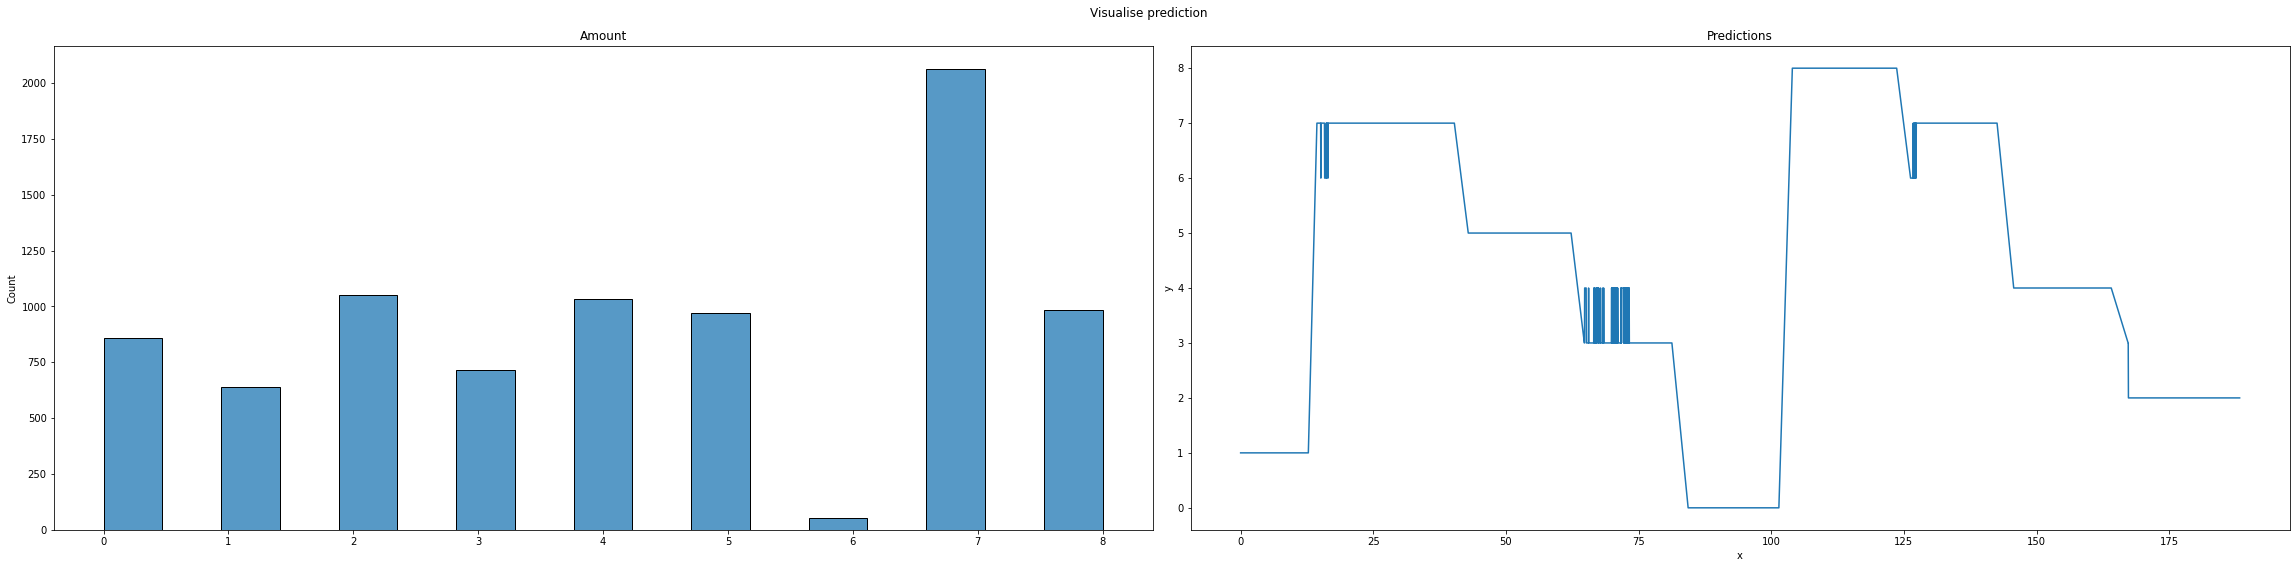

In [13]:
df_predict = pd.DataFrame({'x': knn_test.df[' TimeStamp (s)'],'y':predictions_final})

fig, axes = plt.subplots(1, 2, figsize=(width, height))
sns.histplot(ax=axes[0], data=predictions_final)
sns.lineplot(ax=axes[1], data=df_predict,x='x',y='y')
fig.suptitle('Visualise prediction')
cols = ['Amount', 'Predictions']
for ax, col in zip(axes, cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

In [14]:
model.save("../../ANN_model.h5")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>